In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [3]:
predictors = list(df.columns)[10:]
print(len(predictors))
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

331


In [4]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(298139, 341) (33115, 341)


In [5]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [6]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [10]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [12]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_predictors\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [ ]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.816531
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[5]	validation-auc:0.845817


max_depth = 4, eta = 0.02:
[0]	validation-auc:0.816531
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[6]	validation-auc:0.846846


max_depth = 4, eta = 0.05:
[0]	validation-auc:0.816531
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.868283
[100]	validation-auc:0.878036
[150]	validation-auc:0.8826
[200]	validation-auc:0.885568
[250]	validation-auc:0.887642
[300]	validation-auc:0.888924
[350]	validation-auc:0.890023
[400]	validation-auc:0.890981
[450]	validation-auc:0.891644
[500]	validation-auc:0.892311
[550]	validation-auc:0.89281
[600]	validation-auc:0.893241
[650]	validation-auc:0.893788
[700]	validation-auc:0.894135
[750]	validation-auc:0.894436
[800]	validation-auc:0.894719
[850]	validation-auc:0.895043
[900]	validation-auc:0.89527
[9

[850]	validation-auc:0.891004
[900]	validation-auc:0.891455
[950]	validation-auc:0.891856
[1000]	validation-auc:0.89221
[1050]	validation-auc:0.892514
[1100]	validation-auc:0.892862
[1150]	validation-auc:0.893157
[1200]	validation-auc:0.893431
[1250]	validation-auc:0.893713
[1300]	validation-auc:0.893956
[1350]	validation-auc:0.89414
[1400]	validation-auc:0.89436
[1450]	validation-auc:0.894549
[1500]	validation-auc:0.894734
[1550]	validation-auc:0.89491
[1600]	validation-auc:0.895066
[1650]	validation-auc:0.895211
[1700]	validation-auc:0.895369
[1750]	validation-auc:0.895498
[1800]	validation-auc:0.895603
[1850]	validation-auc:0.895739
[1900]	validation-auc:0.895887
[1950]	validation-auc:0.896023
[2000]	validation-auc:0.89614
[2050]	validation-auc:0.896241
[2100]	validation-auc:0.896338
[2150]	validation-auc:0.896422
[2200]	validation-auc:0.896549
[2250]	validation-auc:0.896657
[2300]	validation-auc:0.896766
[2350]	validation-auc:0.896852
[2400]	validation-auc:0.896941
[2450]	validatio

[200]	validation-auc:0.893971
[250]	validation-auc:0.894994
[300]	validation-auc:0.895897
[350]	validation-auc:0.896428
[400]	validation-auc:0.896945
[450]	validation-auc:0.897337
[500]	validation-auc:0.897639
[550]	validation-auc:0.897911
[600]	validation-auc:0.898115
[650]	validation-auc:0.898416
[700]	validation-auc:0.898541
[750]	validation-auc:0.898685
Stopping. Best iteration:
[744]	validation-auc:0.898708


max_depth = 7, eta = 0.1:
[0]	validation-auc:0.848752
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.888104
[100]	validation-auc:0.893518
[150]	validation-auc:0.895564
[200]	validation-auc:0.896418
[250]	validation-auc:0.897203
[300]	validation-auc:0.897645
Stopping. Best iteration:
[321]	validation-auc:0.897811


max_depth = 7, eta = 0.2:
[0]	validation-auc:0.848752
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.891598
[100]	validation-auc:0.894434
[150]	validation-auc:0.895307
Stopping. Best iteration

In [ ]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.02), 0.89922)
((7, 0.01), 0.898819)
((7, 0.05), 0.898708)
((6, 0.02), 0.898589)
((6, 0.05), 0.898527)
((6, 0.01), 0.898436)
((7, 0.1), 0.897811)
((6, 0.1), 0.897811)
((5, 0.01), 0.897161)
((5, 0.1), 0.897034)
((5, 0.02), 0.896803)
((4, 0.05), 0.896447)
((5, 0.05), 0.896329)
((4, 0.1), 0.896173)
((5, 0.2), 0.895535)
((6, 0.2), 0.895508)
((7, 0.2), 0.895398)
((4, 0.2), 0.894962)
((4, 0.02), 0.846846)
((4, 0.01), 0.845817)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [ ]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.831242
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.863673
[100]	validation-auc:0.871188
[150]	validation-auc:0.876274
[200]	validation-auc:0.879878
[250]	validation-auc:0.882464
[300]	validation-auc:0.884516
[350]	validation-auc:0.886142
[400]	validation-auc:0.887381
[450]	validation-auc:0.888473
[500]	validation-auc:0.889322
[550]	validation-auc:0.890037
[600]	validation-auc:0.890662
[650]	validation-auc:0.891249
[700]	validation-auc:0.891733
[750]	validation-auc:0.892245
[800]	validation-auc:0.892583
[850]	validation-auc:0.893013
[900]	validation-auc:0.893385
[950]	validation-auc:0.893705
[1000]	validation-auc:0.893968
[1050]	validation-auc:0.894219
[1100]	validation-auc:0.894431
[1150]	validation-auc:0.8946
[1200]	validation-auc:0.894795
[1250]	validation-auc:0.895007
[1300]	validation-auc:0.895182
[1350]	validation-auc:0.89534
[1400]	validation-auc:0.895516
[1450]	validation-auc:0.8956

In [ ]:
for t in validation_auc_2.most_common():
    print(t)

((7, 3), 0.898987)
((6, 3), 0.898043)
((6, 5), 0.898031)
((7, 5), 0.898003)
((5, 5), 0.897046)
((5, 3), 0.896964)


#### (3) Grid Search for colsample_by_tree

In [ ]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.849095
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.87592
[100]	validation-auc:0.880413
[150]	validation-auc:0.883929
[200]	validation-auc:0.886474
[250]	validation-auc:0.888612
[300]	validation-auc:0.890408
[350]	validation-auc:0.891659
[400]	validation-auc:0.892656
[450]	validation-auc:0.893453
[500]	validation-auc:0.894087
[550]	validation-auc:0.894638
[600]	validation-auc:0.895148
[650]	validation-auc:0.895535
[700]	validation-auc:0.895921
[750]	validation-auc:0.896217
[800]	validation-auc:0.896516
[850]	validation-auc:0.896774
[900]	validation-auc:0.897013
[950]	validation-auc:0.897232
[1000]	validation-auc:0.897419
[1050]	validation-auc:0.897621
[1100]	validation-auc:0.897776
[1150]	validation-auc:0.897926
[1200]	validation-auc:0.898056
[1250]	validation-auc:0.898193
[1300]	validation-auc:0.89832
[1350]	validation-auc:0.898445
[1400]	validation-auc:0.898525
[1450]	validation-auc:0.898632
[1500]	v

[800]	validation-auc:0.896418
[850]	validation-auc:0.896731
[900]	validation-auc:0.896959
[950]	validation-auc:0.897176
[1050]	validation-auc:0.897501
[1100]	validation-auc:0.897627
[1150]	validation-auc:0.897801
[1200]	validation-auc:0.89791
[1250]	validation-auc:0.89805
[1300]	validation-auc:0.898153
[1350]	validation-auc:0.898256
[1400]	validation-auc:0.898338
Stopping. Best iteration:
[1427]	validation-auc:0.898386


colsample_by_tree = 0.9:
[0]	validation-auc:0.849029
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.873096
[100]	validation-auc:0.879158
[150]	validation-auc:0.883029
[200]	validation-auc:0.886221
[250]	validation-auc:0.888524
[300]	validation-auc:0.890308
[350]	validation-auc:0.89171
[400]	validation-auc:0.892697
[450]	validation-auc:0.893528
[500]	validation-auc:0.894133
[550]	validation-auc:0.894688
[600]	validation-auc:0.895131
[650]	validation-auc:0.89555
[700]	validation-auc:0.895994
[750]	validation-auc:0.896323
[800]	validat

In [ ]:
validation_auc_3.most_common()

[(0.8, 0.898987),
 (0.65, 0.898849),
 (0.55, 0.898841),
 (0.7, 0.898793),
 (0.5, 0.89879),
 (0.75, 0.898736),
 (0.9, 0.898607),
 (0.85, 0.898386),
 (0.6, 0.898346)]

#### (4) Finally select the opitmal num_boost_round

In [12]:
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.848901
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.874165
[100]	validation-auc:0.879413
[150]	validation-auc:0.883266
[200]	validation-auc:0.886281
[250]	validation-auc:0.888535
[300]	validation-auc:0.890333
[350]	validation-auc:0.89168
[400]	validation-auc:0.892656
[450]	validation-auc:0.893498
[500]	validation-auc:0.894144
[550]	validation-auc:0.894724
[600]	validation-auc:0.895208
[650]	validation-auc:0.895594
[700]	validation-auc:0.89602
[750]	validation-auc:0.896354
[800]	validation-auc:0.8966
[850]	validation-auc:0.896894
[900]	validation-auc:0.897126
[950]	validation-auc:0.897307
[1000]	validation-auc:0.897486
[1050]	validation-auc:0.897626
[1100]	validation-auc:0.897755
[1150]	validation-auc:0.897901
[1200]	validation-auc:0.898022
[1250]	validation-auc:0.898132
[1300]	validation-auc:0.89827
[1350]	validation-auc:0.898412
[1400]	validation-auc:0.898527
[1450]	validation-auc:0.898598
[1500]	validation-auc:0.898692
[1550

#### (5) Train the final xgb model and make predictions for observations in the test set

In [13]:
optimal_num_boost_round = 1670

In [14]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [23]:
y_test_pred = final_xgb_model.predict(dtest)

In [25]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.9032


In [28]:
# save the model object and predicted scores on the validation sample to local disk
pickle.dump(final_xgb_model, open(fpath + "/xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(fpath + "/y_test_pred_xgb.p", "wb"))

In [ ]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

In [ ]:
xgb_summary = feature_importance.rename(columns = {'feature':'predictor_name',
                                                   'importance':'feature_importance'})\
.loc[:,['predictor_name', 'feature_importance']]
xgb_summary = xgb_summary.merge(pd.DataFrame({'predictor_name': predictors}), on=['predictor_name'], how='right')\
.sort_values(['feature_importance', 'predictor_name'], ascending=[False, True]).fillna(0)
xgb_summary.to_csv(results_dir + "xgb_summary.csv", index=False)

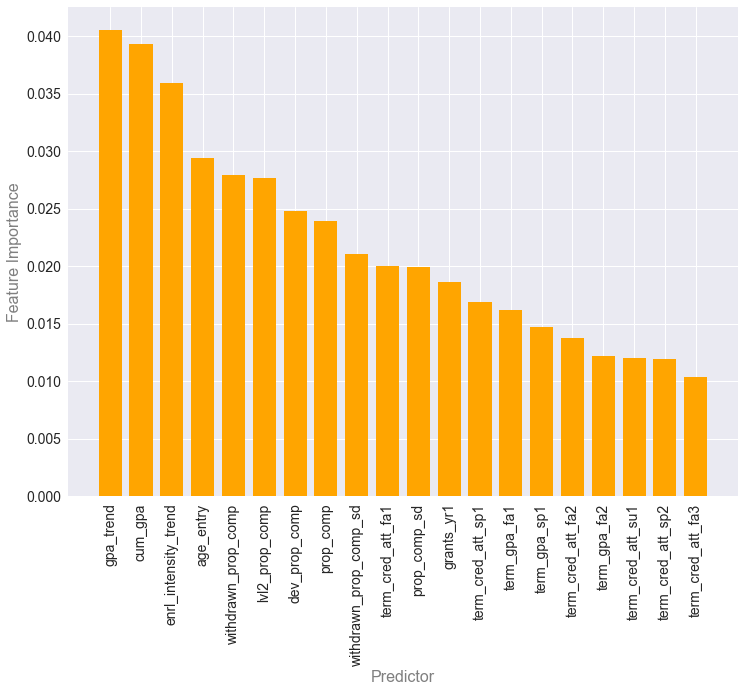

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [30]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [ ]:
final_params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.8, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.9006865087709615 0.0018520354206715312


In [2]:
best_threshold

0.38526425

In [ ]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [ ]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.385:

         Pred_0   Pred_1         
Real_0  18789.0   3019.0  21808.0
Real_1   2296.0   9011.0  11307.0
        21085.0  12030.0  33115.0

F1 score = 0.7723


In [ ]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.431:

         Pred_0   Pred_1         
Real_0  19209.0   2599.0  21808.0
Real_1   2580.0   8727.0  11307.0
        21789.0  11326.0  33115.0

F1 score = 0.7712


In [ ]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the four base models: OLS, Logit, RF, XGBoost

In [16]:
# Key evaluation metrics used to generate Figure 3, Figure 2 and Appendix Table A1 of the paper
cstat = [0.8837,0.8795,0.8859,0.9032]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost'}
m_list = ['Logit', 'OLS', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.round(4).to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)

In [17]:
import os
os.chdir("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_predictors")

In [18]:
import shutil
m2_dict = {'lr':'Logit','xgb':'XGBoost','ols':'OLS','rf':'RF'}
for f in [e + ".csv" for e in ['lr_feature_ranking','ols_feature_ranking','rf_summary','xgb_summary']]:
    m = f.split("_")[0]
    try:
        shutil.copy(f, "cleaned_results\\feature_ranking\\"+m2_dict[m]+"_feature_ranking.csv")
    except KeyError:
        shutil.copy(f, "cleaned_results\\feature_ranking\\"+m+"_feature_ranking.csv")

In [19]:
for f in [e + '_summary.csv' for e in ['lr','ols']]:
    m = f.split("_")[0]
    shutil.copy(f, "cleaned_results\\coefficients\\{}_coef.csv".format(m2_dict[m]))

In [1]:
pred_score_dict = {}
for k,v in m2_dict.items():
    pred_score_dict[v] = pickle.load(open(fpath+"/y_test_pred_{}.p".format(k), "rb"))
pd.DataFrame(pred_score_dict, index=list(test_df.vccsid)).sort_index().to_csv(results_dir+"cleaned_results//all_pred_scores.csv")